In [4]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 102.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 106.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.4 MB/s eta 0:00:00


In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Attention, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

In [9]:
import tensorflow as tf

# 尝试使用 TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

# 如果 TPU 不可用，尝试使用 GPU
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print("使用TPU")
else:
    # 如果 GPU 可用，则使用 GPU
    if tf.config.list_physical_devices('GPU'):
        strategy = tf.distribute.MirroredStrategy() # 使用GPU
        print("使用GPU")
    else:
        # 使用 CPU
        strategy = tf.distribute.get_strategy()
        print("使用CPU")

# 打印当前使用的硬件
print("当前使用的硬件:", strategy)


使用GPU
当前使用的硬件: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7db60ff41010>


In [10]:
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load data
print("Loading data...")
file_path = "dga_domains_full.csv"
data = pd.read_csv(file_path)
print(data.head())

# Map DGA to binary labels
data["label"] = data["label"].map({"dga": 1, "legit": 0})

# Extract domain names and labels
domains = data['domains'].values
labels = data['label'].values

# Preprocess domains
print("Preprocessing domains...")
# Convert domains to lowercase
domains = np.array([domain.lower() for domain in domains])

# Tokenize domains
max_length = 60  # Maximum length of domain names
tokenizer = Tokenizer(char_level=True)  # Character-level tokenization
tokenizer.fit_on_texts(domains)
sequences = tokenizer.texts_to_sequences(domains)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, labels, test_size=0.2, random_state=42
)

Loading data...
   label    group                           domains
0    dga     gozi            mortiscontrastatim.com
1    dga  corebot  cvyh1po636avyrsxebwbkn7.ddns.net
2  legit    alexa                plasticbags.sa.com
3  legit    alexa                      mzltrack.com
4  legit    alexa                      miss-slim.ru
Preprocessing domains...


In [23]:
# Define model architecture with LSTM and Attention
print("Building LSTM + Attention model...")

# Vocabulary size (number of unique characters)
vocab_size = len(tokenizer.word_index) + 1

# Define custom Attention layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                               initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                               initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # Calculate attention scores
        e = tf.nn.tanh(tf.matmul(x, self.W) + self.b)
        # Get attention weights
        a = tf.nn.softmax(e, axis=1)
        # Apply attention weights to the input
        output = x * a
        # Sum over the sequence dimension
        return tf.reduce_sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

# Build the model
def build_model():
    # Input layer
    inputs = Input(shape=(max_length,))
    # Embedding layer
    embedding_layer = Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=max_length)(inputs)

    # Bidirectional LSTM layer
    lstm_layer = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
    # Apply Attention
    attention_layer = AttentionLayer()(lstm_layer)
    # Dense layers
    x = Dense(64, activation='relu')(attention_layer)
    x = Dropout(0.4)(x)
    # Output layer
    outputs = Dense(1, activation='sigmoid')(x)
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    # Compile model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Create and display model summary
model = build_model()
model.summary()

Building LSTM + Attention model...


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 60, 64)         │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 60, 256)        │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_3               │ (None, 256)            │           316 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,021 (847.74 KB)

 Trainable params: 217,021 (847.74 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Train the model
print("Training model...")
batch_size = 128
epochs = 10

# --- 定义 EarlyStopping 回调 ---
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=[early_stopping]
)

Training model...
Epoch 1/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 54s 15ms/step - accuracy: 0.8309 - loss: 0.3689 - val_accuracy: 0.9168 - val_loss: 0.1982
Epoch 2/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 50s 15ms/step - accuracy: 0.9291 - loss: 0.1757 - val_accuracy: 0.9520 - val_loss: 0.1238
Epoch 3/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - accuracy: 0.9563 - loss: 0.1173 - val_accuracy: 0.9620 - val_loss: 0.1008
Epoch 4/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - accuracy: 0.9652 - loss: 0.0946 - val_accuracy: 0.9680 - val_loss: 0.0880
Epoch 5/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - accuracy: 0.9718 - loss: 0.0783 - val_accuracy: 0.9718 - val_loss: 0.0804
Epoch 6/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 81s 15ms/step - accuracy: 0.9770 - loss: 0.0653 - val_accuracy: 0.9719 - val_loss: 0.0813
Epoch 7/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - accuracy: 0.9804 - loss: 0.0553 - val_accuracy: 0.9743 - val_loss: 0.0770
Epoch 8/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - 

In [25]:
# Evaluate the model
print("Evaluating model...")
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {accuracy:.4f}")

Evaluating model...
4219/4219 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9739 - loss: 0.0884
Test Accuracy: 0.9742


In [27]:
# Generate predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

4219/4219 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     67289
           1       0.97      0.98      0.97     67691

    accuracy                           0.97    134980
   macro avg       0.97      0.97      0.97    134980
weighted avg       0.97      0.97      0.97    134980



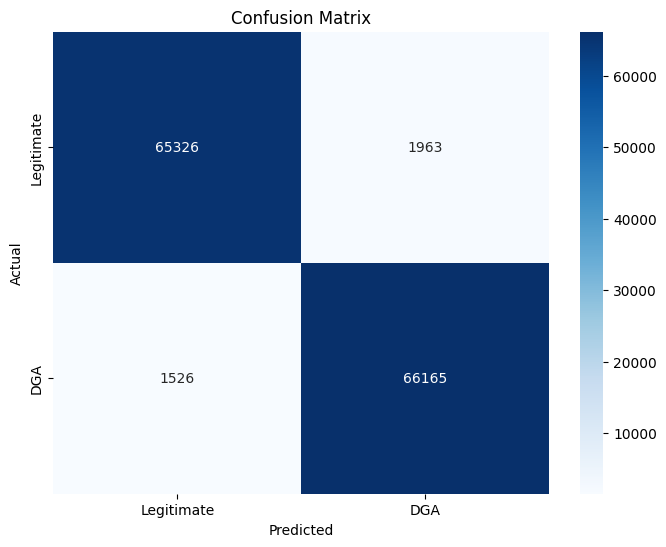

In [28]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'DGA'],
            yticklabels=['Legitimate', 'DGA'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
# plt.savefig('confusion_matrix.png')
plt.show()
plt.close()

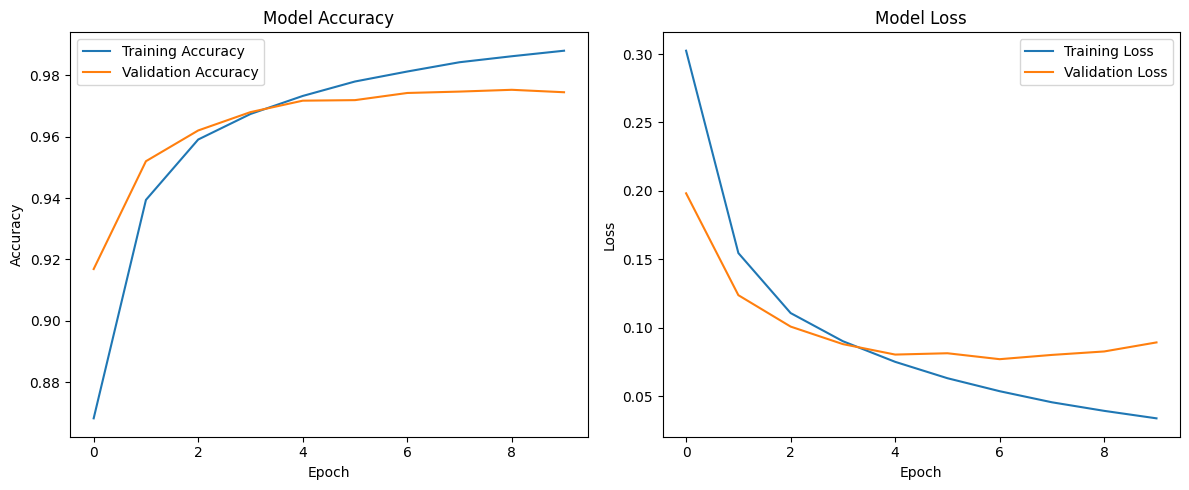

In [29]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
# plt.savefig('training_history.png')
plt.show()
plt.close()

In [30]:
# Save model and tokenizer
print("Saving model and tokenizer...")
model.save('dga_lstm_attention_model.h5')

# Save tokenizer
with open('dga_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save max_length
with open('dga_config.pickle', 'wb') as handle:
    config = {'max_length': max_length}
    pickle.dump(config, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Model and preprocessing components saved successfully!")

Saving model and tokenizer...
Model and preprocessing components saved successfully!


In [31]:
# Function to test a single domain
def predict_domain(domain, model, tokenizer, max_length):
    domain = domain.lower()
    sequence = tokenizer.texts_to_sequences([domain])
    padded = pad_sequences(sequence, maxlen=max_length, padding='post')
    prediction = model.predict(padded)[0][0]
    return {
        'domain': domain,
        'prediction': 'DGA' if prediction > 0.5 else 'Legitimate',
        'confidence': float(prediction) if prediction > 0.5 else float(1 - prediction)
    }

# Test a few examples
test_domains = [
    "google.com",
    "facebook.com",
    "asdfjkl123456.com",
    "xyzabcdefghijklm.net",
    "amazonprime.com",
    "qwertyuiop123456.ru"
]

print("\nTesting model with example domains:")
for domain in test_domains:
    result = predict_domain(domain, model, tokenizer, max_length)
    print(f"Domain: {result['domain']}")
    print(f"Prediction: {result['prediction']} (Confidence: {result['confidence']:.4f})")
    print("---")

print("Done!")


Testing model with example domains:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Domain: google.com
Prediction: Legitimate (Confidence: 1.0000)
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Domain: facebook.com
Prediction: Legitimate (Confidence: 1.0000)
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Domain: asdfjkl123456.com
Prediction: Legitimate (Confidence: 0.7486)
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Domain: xyzabcdefghijklm.net
Prediction: DGA (Confidence: 1.0000)
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Domain: amazonprime.com
Prediction: Legitimate (Confidence: 1.0000)
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Domain: qwertyuiop123456.ru
Prediction: DGA (Confidence: 0.9989)
---
Done!
